# Exploration of advection-diffusion versus threshold model of landscape development.

## Advection-Diffusion model exploration

We first plot the topography that is expected from the flow routing calculated from the Allegheny DEM, and compare this to the real topography.  The parameters for the Gabilans are taken directly from Perron et al. (2012).  We start with a small DEM for computational reasons.

In all simulations, we use the elevations of the boundaries, as contained within the real DEM to set the boundary conditions of the model.  The elevations are then integrated from this boundary using a finite-difference approximation of the different types of landscape development models.

**Governing equation (advection--diffusion):**

$$
0 = U - K A^m \frac{\partial z}{\partial x} + D \nabla^2 z
$$

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path("../../src")))

import numpy as np
import matplotlib.pyplot as plt
from TopoAnalysis import dem as d
from scipy.stats import linregress
from models import advection_diffusion_model
from utils import crop
from optimization import (
    optimize_advection_diffusion,
    optimize_threshold_acrit,
    optimize_threshold_acrit_nonlinear,
    optimize_threshold_full,
)
from utils import save_model_outputs, compute_slope_magnitude

# CHANGE THESE PER TILE:

base = "../../data/AP/tile2/"
base_save = "../../data/AP/tile2/outputs/"
SAVE = True        # Toggle saving on/off

concavity = 0.592
hilltop_curvature = 1.944E-2
steepness = 190.918

# TOUCH NOTHING ELSE:

elev_path = base + "AP_1m_best_tile_filled"
area_path = base + "AP_1m_best_tile_area"
flow_path = base + "AP_1m_best_tile_fd"

U = 5.5e-5
n = 1.0
m = concavity
K0, D0 = np.power(U/steepness,1/n), U/hilltop_curvature

K_bounds = (1.0e-12, 2.0e-2)
D_bounds = (4.0e-7, 5e-2)

print(K0, D0)

# ─── Load data ──────────────────────────────────────────
dem = d.Elevation.load(elev_path)
area = d.Area.load(area_path)
flow_direction = d.FlowDirectionD8.load(flow_path)

advection_diffusion = advection_diffusion_model(dem, area, flow_direction, m)

2.880817942781718e-07 0.002829218106995885


completed flow graph in: 5.646581649780273 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100completed flow graph in: 5.640449047088623 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

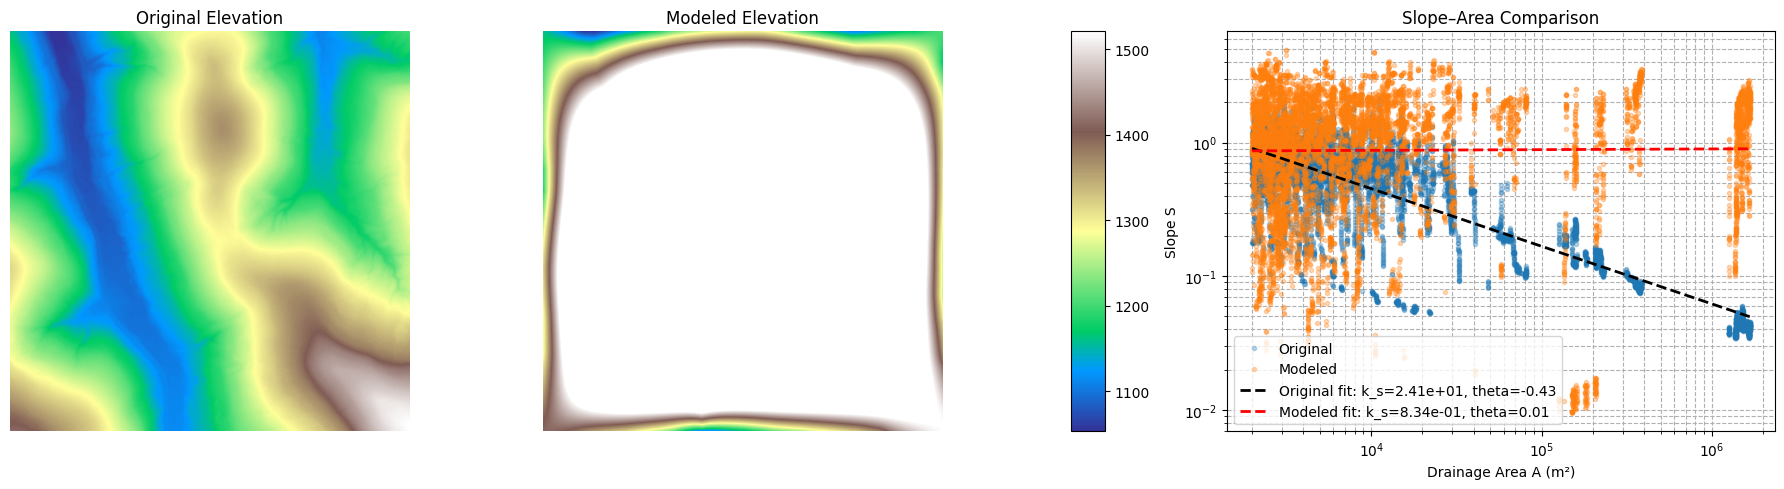

[saved optimized grids to '../../data/AP/tile2/outputs/']


In [2]:
from plotting import plot_maps_area_slope

Z_model = advection_diffusion(U, K0, D0)
plot_maps_area_slope(dem, area, flow_direction, Z_model)

if SAVE:
    save_model_outputs(dem, Z_model, base_save, "AP_1m_best_tile_AD-no-opt")
    print(f"[saved optimized grids to '{base_save}']")

### Given that the advection diffusion equation cannot reproduce the relief in this landscape, what combinations of K and D can?

We set up an optimization problem by comparing measured and modeled elevations across the tile, and minimizing their squared difference by adjusting K and D.

In [3]:
K_star, D_star, mse_star = optimize_advection_diffusion(
    advection_diffusion, dem._griddata, U, K0, D0, K_bounds, D_bounds,
)
print("\n\U0001f389 Optimal parameters:")
print(f"   K = {K_star:.4e}")
print(f"   D = {D_star:.4e}")
print(f"   MSE = {mse_star:.4e}")



🎉 Optimal parameters:
   K = 6.9594e-06
   D = 6.6607e-04
   MSE = 3.8149e+02


completed flow graph in: 5.626933336257935 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100completed flow graph in: 5.68143892288208 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

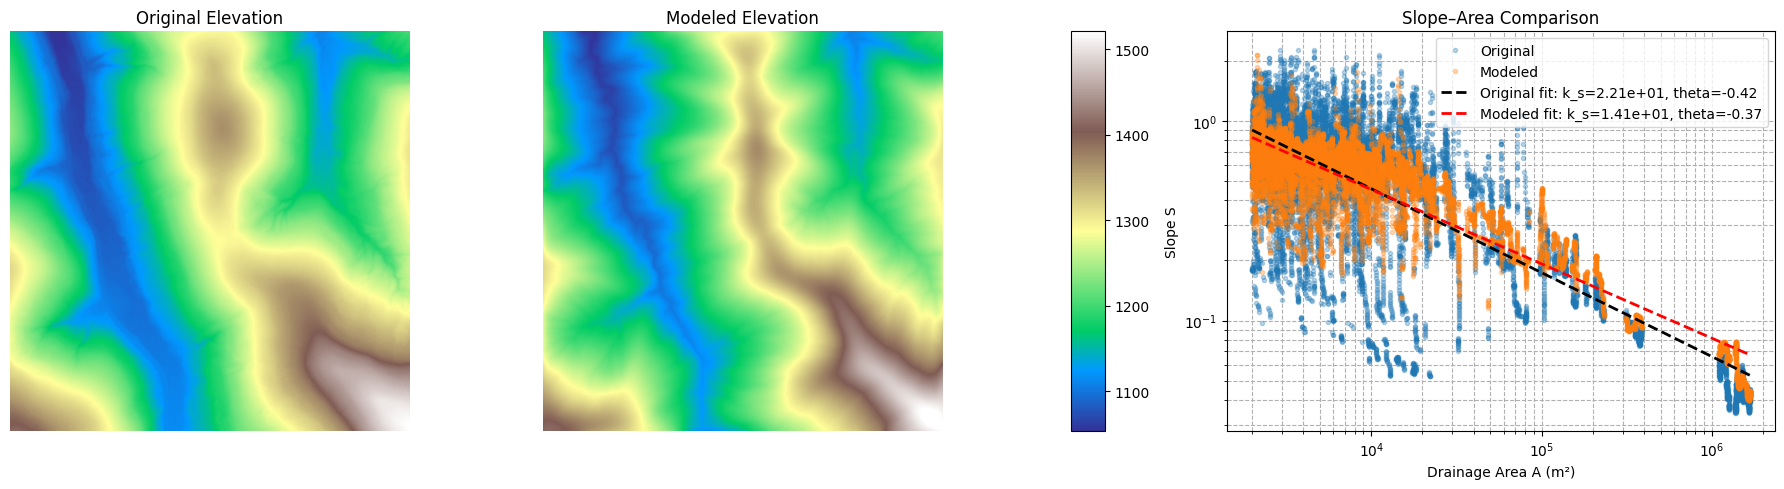

[saved optimized grids to '../../data/AP/tile2/outputs/']


In [4]:
Z_model = advection_diffusion(U, K_star, D_star)

plot_maps_area_slope(dem, area, flow_direction, Z_model)

if SAVE:
    save_model_outputs(dem, Z_model, base_save, "AP_1m_best_tile_AD-opt")
    print(f"[saved optimized grids to '{base_save}']")

## We next consider the threshold landscape model.  In this case, diffusion acts in areas of the landscape where $ A \le A_{crit}$ whereas incision occurs where $A > A_{crit}$.  

We first explore the topography expected from Peron's K, D values for the Gabilans for differing $A_{crit}$.

**Governing equations (threshold landscape model):**

Channels where $A > A_{\mathrm{crit}}$:

$$
0 = U - K A^m \frac{\partial z}{\partial x}
$$

Hillslopes where $A \le A_{\mathrm{crit}}$, with linear sediment flux $q_s = -D\nabla z$:

$$
0 = U + D\nabla^2 z
$$

In [5]:
from models import partitioned_threshold_model
from utils import crop
import importlib
import plotting
importlib.reload(plotting)
from plotting import plot_maps_and_channel_mask

partitioned_model = partitioned_threshold_model(dem, area, flow_direction, m, U, K0)

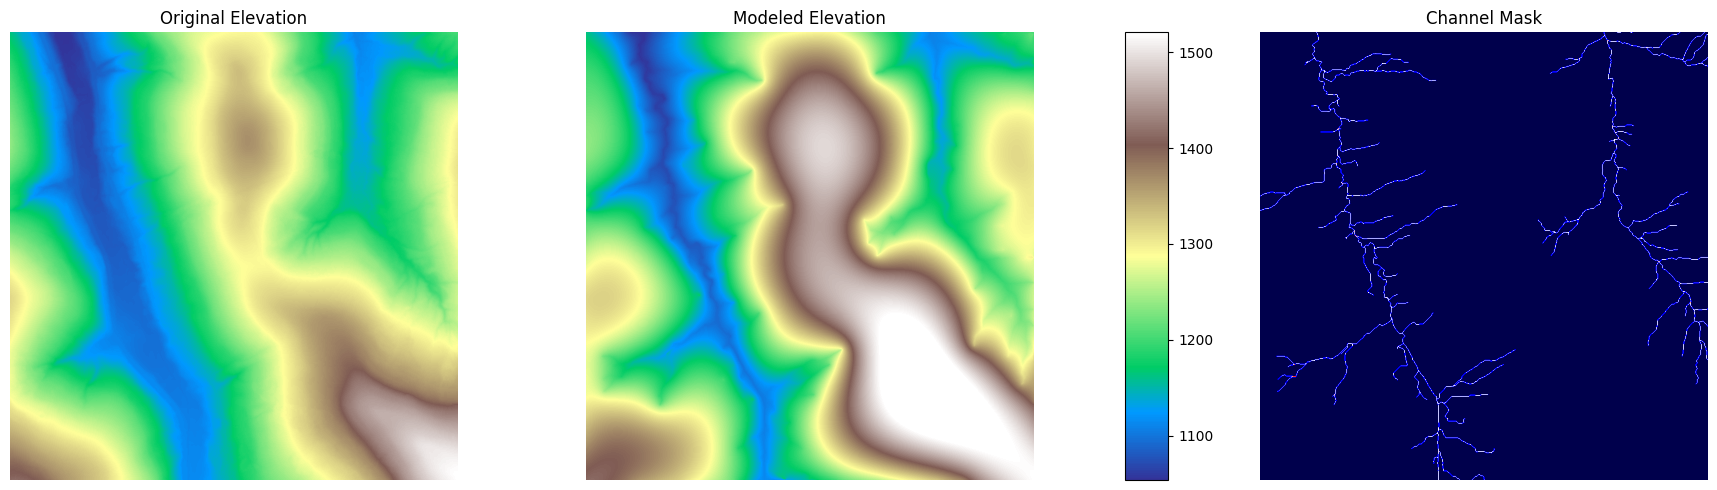

In [6]:
A_crit = 5E3

Z_model, mask = partitioned_model(A_crit, D0)

plot_maps_and_channel_mask(dem, Z_model, mask)

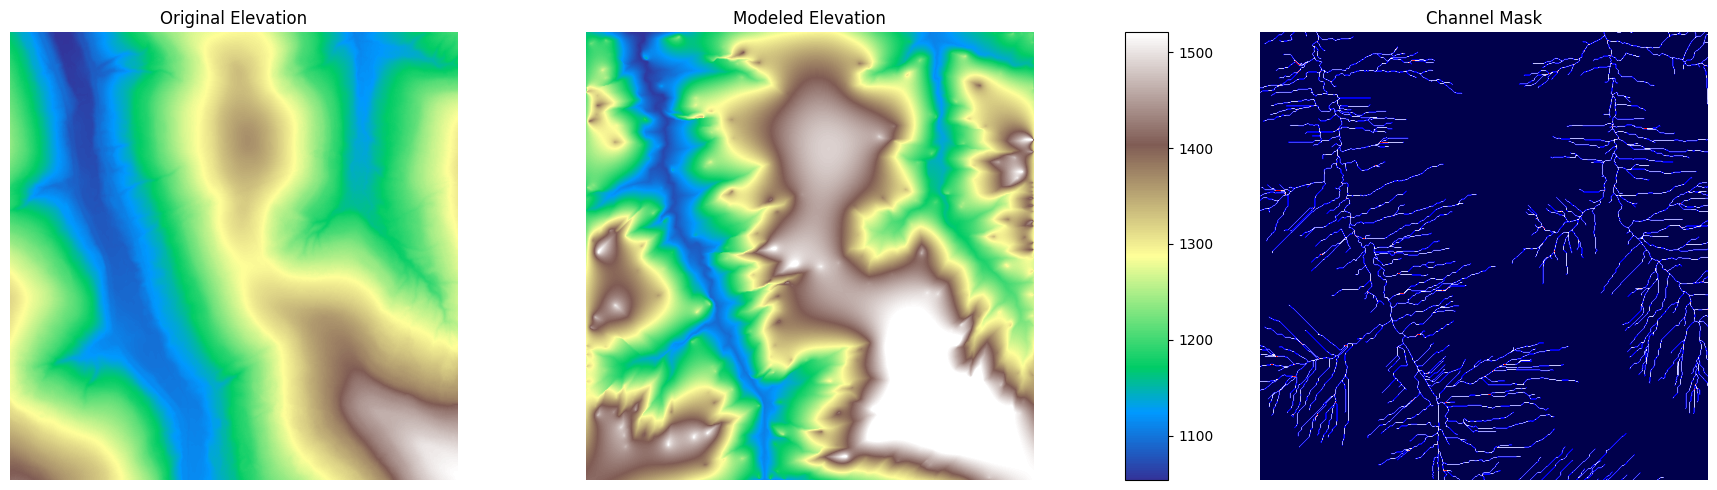

In [7]:
A_crit = 1E3 # 

Z_model, mask = partitioned_model(A_crit, D0)

plot_maps_and_channel_mask(dem, Z_model, mask)

In [8]:
A_crit = 5E2 # 

Z_model, mask = partitioned_model(A_crit, D0)

plot_maps_and_channel_mask(dem, Z_model, mask)

In [9]:
A_crit = 1E2 # 

Z_model, mask = partitioned_model(A_crit, D0)

plot_maps_and_channel_mask(dem, Z_model, mask)

### Next, we optimize as before by varying $A_{crit}$ to find best-fitting topography.

In [10]:
A_crit_0 = 5000
A_crit_bounds = (1E2, 1E5)

A_crit_star, mse_star = optimize_threshold_acrit(
    partitioned_model, dem._griddata, D0, A_crit_0, A_crit_bounds,
)
print("\n\U0001f389 Optimal parameters:")
print(f"   A_crit = {A_crit_star:.4e}")
print(f"   MSE = {mse_star:.4e}")



🎉 Optimal parameters:
   A_crit = 2.3378e+03
   MSE = 4.2274e+03


completed flow graph in: 5.638670921325684 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100completed flow graph in: 5.6757261753082275 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

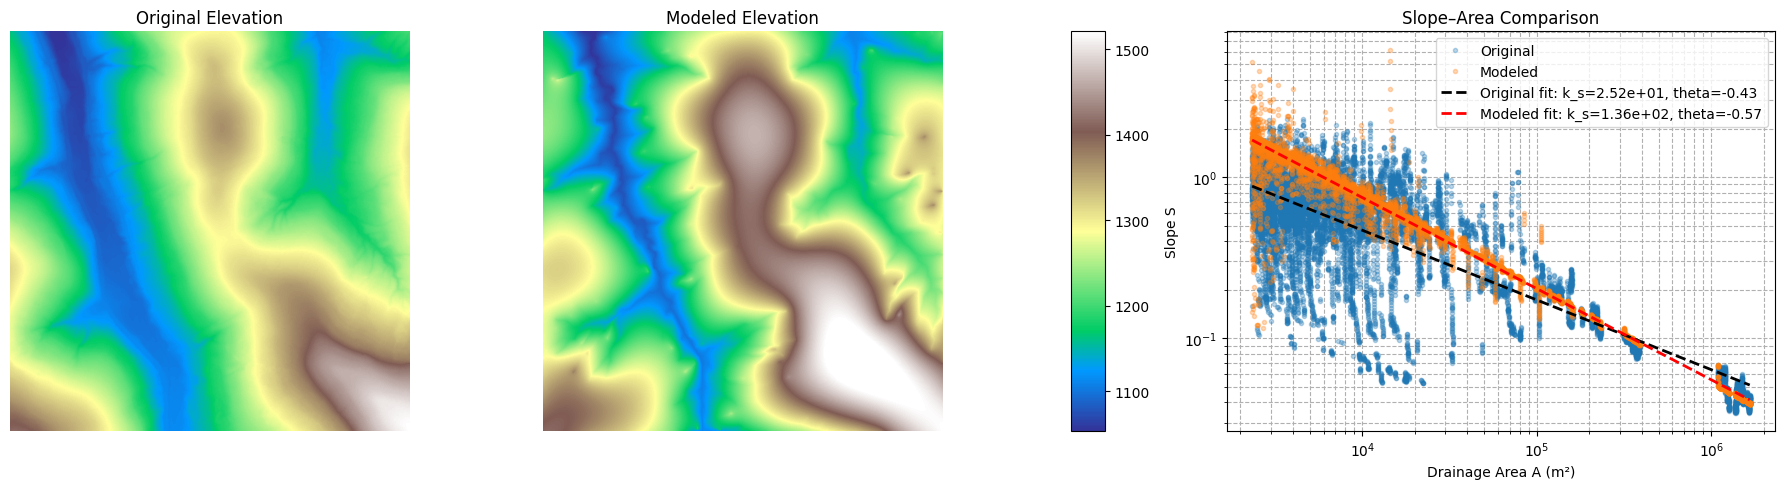

[saved optimized grids to '../../data/AP/tile2/outputs/']


In [11]:
from scipy.stats import linregress

# ─── Plotting ──────────────────────────────────────
Z_model, channel_mask = partitioned_model(A_crit_star, D0)

plot_maps_area_slope(dem, area, flow_direction, Z_model, channel_mask)

if SAVE:
    save_model_outputs(dem, Z_model, base_save, "AP_1m_best_tile_Partitioned-model-a_crit-opt")
    print(f"[saved optimized grids to '{base_save}']")

## The next set of experiments will be to examine the impact of non-linear diffusion on the best-fitting topography.

We'll first do a general exploration of the role of non-linear diffusion on the topography.

First, let's determine the slope distributions for the best-fitting model to determine whether they may produce substantial non-linear hillslope transport.

**Nonlinear hillslope sediment flux:**

$$
q_s = \frac{-D \nabla z}{1 - (|\nabla z|/S_c)^2}
$$

(array([ 2824., 10394., 16146., 21812., 28484., 32984., 39888., 46816.,
        53339., 56943., 60478., 61679., 66452., 68686., 71080., 67738.,
        63002., 50196., 38819.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]),
 <BarContainer object of 19 artists>)

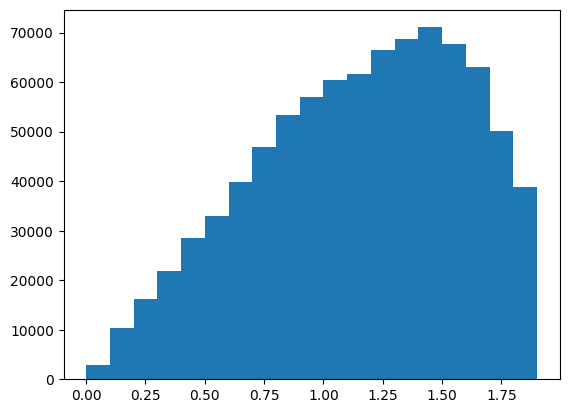

In [12]:
hillslope_mask = ~channel_mask

s = compute_slope_magnitude(Z_model)
plt.hist(s[hillslope_mask], bins = np.arange(0,2,0.1))

(array([34981., 66113., 60140., 49234., 38403., 29766., 22620., 17766.,
        16060., 12605., 10283.,  8585.,  7405.,  6525.,  5749.,  4955.,
         4513.,  4192.,  3791.,  3348.,  3086.,  2797.,  2675.,  2497.,
         2210.,  2064.,  1921.,  1781.,  1701.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029]),
 <BarContainer object of 29 artists>)

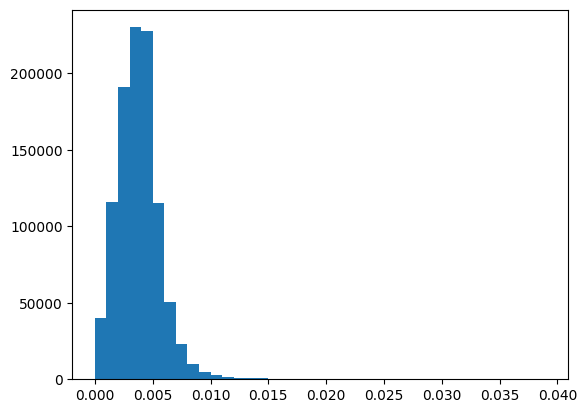

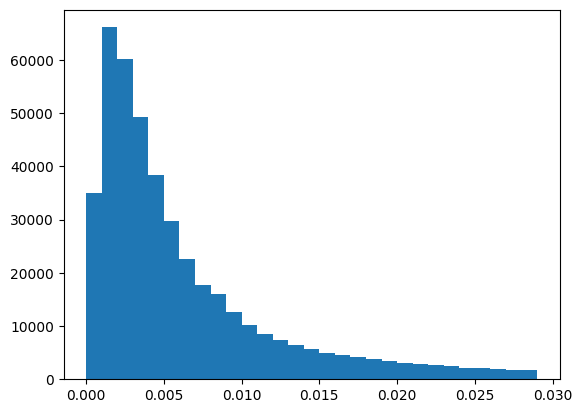

In [13]:
Sc = 1.27

plt.figure()
plt.hist(D0*s[hillslope_mask], bins = np.arange(0,0.04,0.001))
plt.figure()
plt.hist(s[hillslope_mask]*D0 / (1 - np.power(s[hillslope_mask]/Sc,2)), bins = np.arange(0, 0.03, 0.001))

### Next, let's perform a forward exploration of the effect of non-linear transport and how this might vary with A_crit.

In [14]:
from models import partitioned_threshold_model_nonlinear

Sc = 1.27

partitioned_model_nonlinear = partitioned_threshold_model_nonlinear(dem, area, flow_direction, m, U, K0)

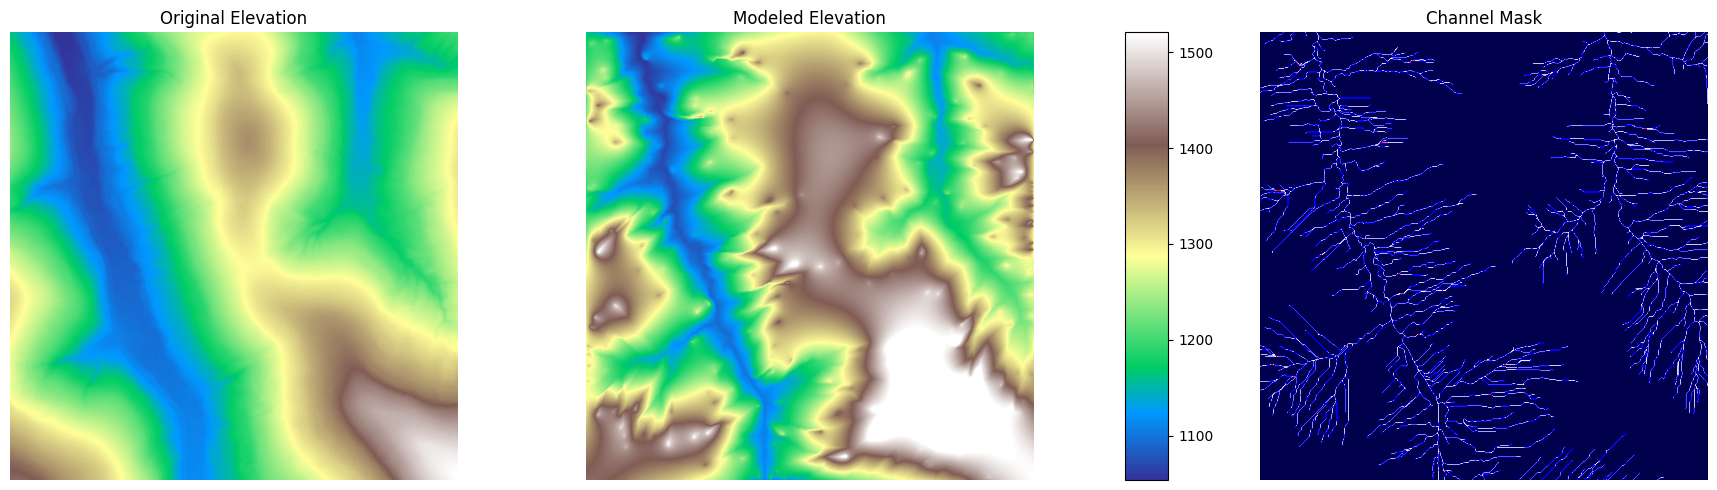

In [15]:
A_crit = 1E3

Z_model, mask = partitioned_model_nonlinear(A_crit, D0, Sc)

plot_maps_and_channel_mask(dem, Z_model, mask)

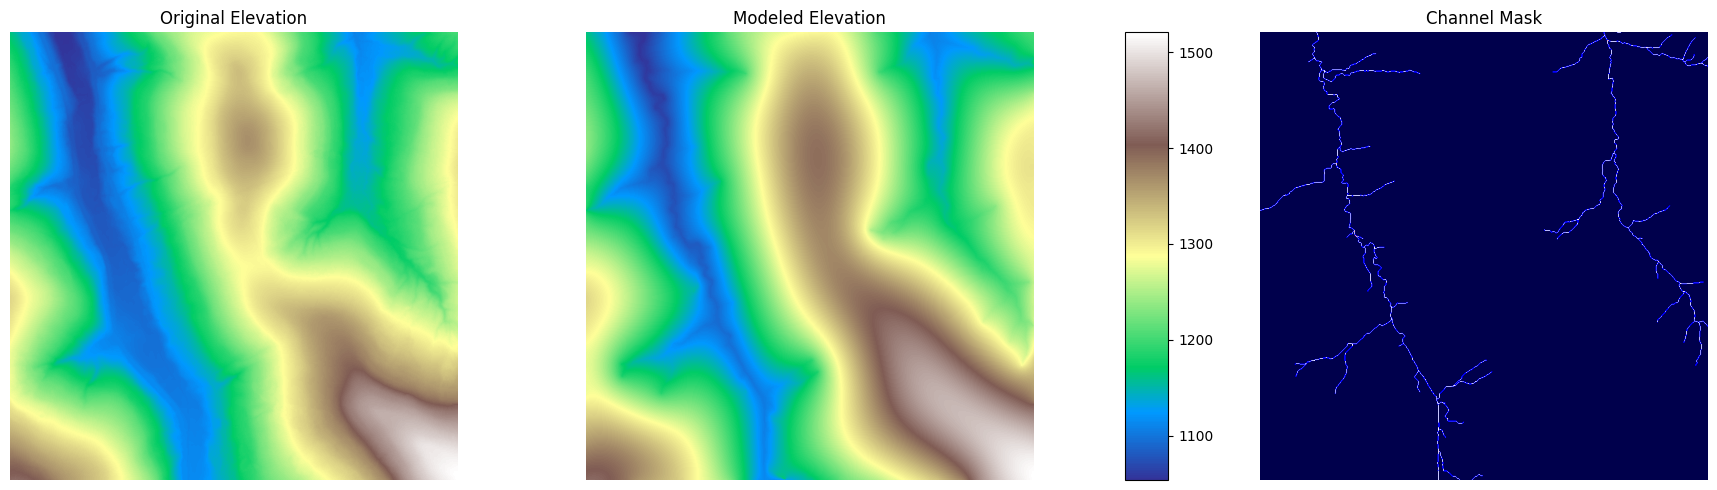

In [16]:
A_crit = 1E4

Z_model, mask = partitioned_model_nonlinear(A_crit, D0, Sc)

plot_maps_and_channel_mask(dem, Z_model, mask)

### Let's next repeat the optimization of $A_{crit}$ using the nonlinear diffusion framework.

In [17]:
A_crit_0 = 5000
A_crit_bounds = (1E2, 1E5)

A_crit_star, mse_star = optimize_threshold_acrit_nonlinear(
    partitioned_model_nonlinear, dem._griddata, D0, Sc, A_crit_0, A_crit_bounds,
)
print("\n\U0001f389 Optimal parameters:")
print(f"   A_crit = {A_crit_star:.4e}")
print(f"   MSE = {mse_star:.4e}")



🎉 Optimal parameters:
   A_crit = 6.1659e+03
   MSE = 6.3032e+02


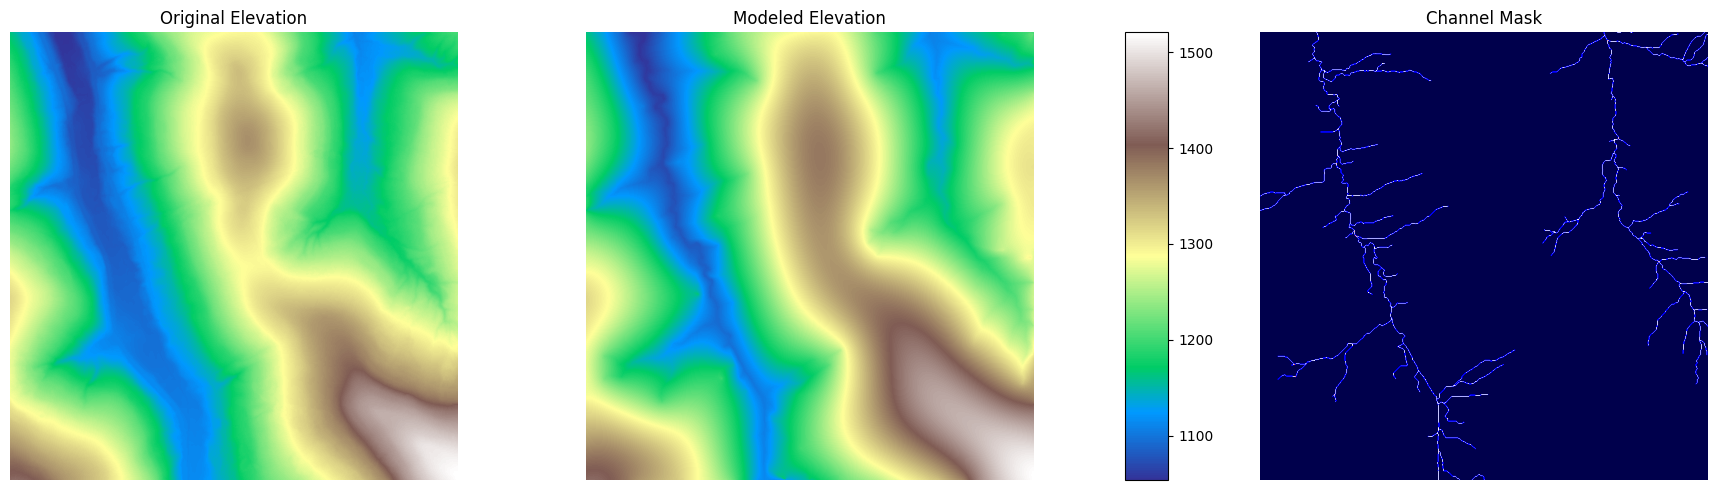

In [18]:
Z_model, mask = partitioned_model_nonlinear(A_crit_star, D0, Sc)

plot_maps_and_channel_mask(dem, Z_model, mask)

### The nonlinear model does a bit better than the linear model, which in turn is better than the advection diffusion model.

Let's perform a final set of experiments in which we allow K and D (and $A_{crit}$) to vary to optimize the topography within the context of the threshold landscape model.

In [19]:
A_crit_0 = 5000
A_crit_bounds = (1E2, 1E5)

A_crit_star, D_star, K_star, mse_star = optimize_threshold_full(
    dem, area, flow_direction, m, U, dem._griddata,
    K0, D0, A_crit_0, K_bounds, D_bounds, A_crit_bounds,
)
print("\n\U0001f389 Optimal parameters:")
print(f"   D = {D_star:.4e}")
print(f"   K = {K_star:.4e}")
print(f"   A_crit = {A_crit_star:.4e}")
print(f"   MSE = {mse_star:.4e}")



🎉 Optimal parameters:
   D = 7.0857e-03
   K = 3.5072e-07
   A_crit = 7.6456e+03
   MSE = 2.3350e+02


completed flow graph in: 5.588822364807129 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100completed flow graph in: 5.5944671630859375 s
Percent completion...10...20...30...40...50...60...70...80...89...99...Percent completion...100

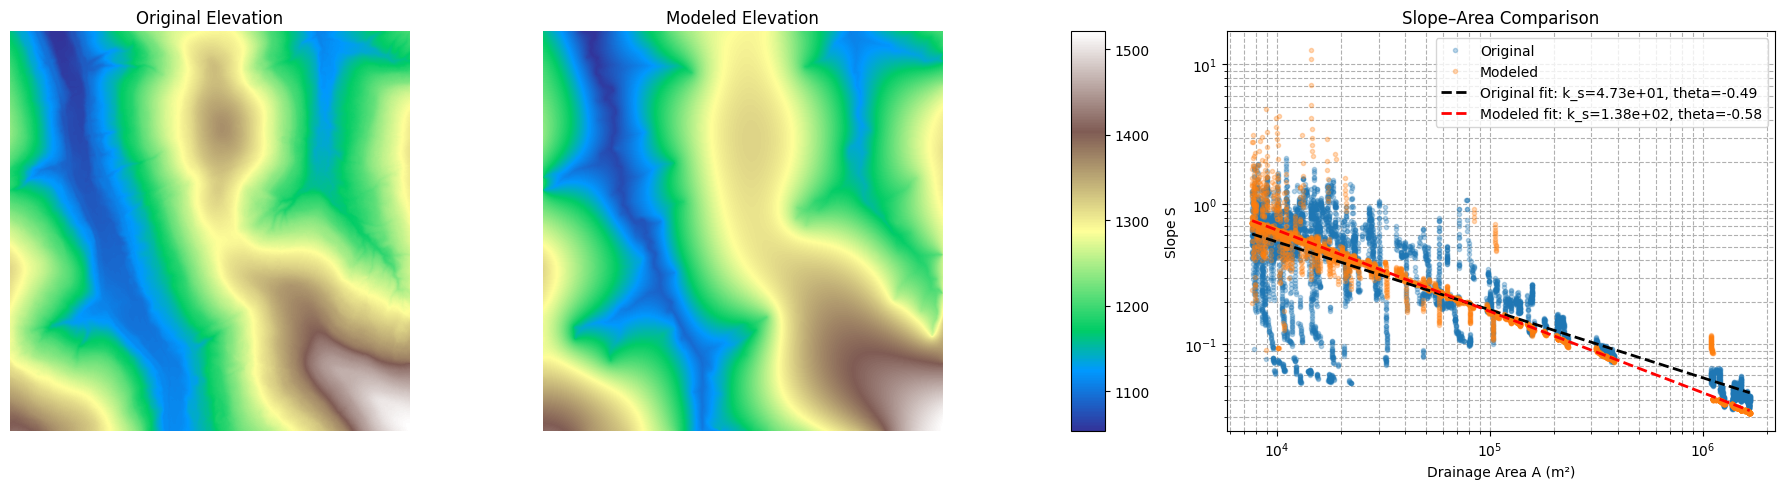

[saved optimized grids to '../../data/AP/tile2/outputs/']


In [20]:
partitioned_model_all = partitioned_threshold_model(dem, area, flow_direction, m, U, K_star)

Z_model, channel_mask = partitioned_model_all(A_crit_star, D_star)

plot_maps_area_slope(dem, area, flow_direction, Z_model, channel_mask)

if SAVE:
    save_model_outputs(dem, Z_model, base_save, "AP_1m_best_tile_Partitioned-model-a_crit-k-d-opt")
    print(f"[saved optimized grids to '{base_save}']")